In [32]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
import intel_extension_for_pytorch as ipex
from codecarbon import EmissionsTracker

In [33]:
pip install pybind11

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [35]:
tracker = EmissionsTracker()


[codecarbon INFO @ 17:48:18] [setup] RAM Tracking...
[codecarbon INFO @ 17:48:18] [setup] GPU Tracking...
[codecarbon INFO @ 17:48:18] No GPU found.
[codecarbon INFO @ 17:48:18] [setup] CPU Tracking...
[codecarbon WARNING @ 17:48:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:48:21] We saw that you have a Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:48:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
[codecarbon INFO @ 17:48:21] >>> Tracker's metadata:
[codecarbon INFO @ 17:48:21]   Platform system: Linux-5.4.0-80-generic-x86_64-with-glibc2.31
[codecarbon INFO @ 17:48:21]   Python version: 3.9.16
[codecarbon INFO @ 17:48:21]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 17:48:21]   Available RAM : 187.622 GB
[codecarbon INFO @ 17:48:21]   CPU count: 24
[codecarbon INFO @ 17:48:21]   CPU model: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
[codecarbon I

In [36]:
# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=True)
test_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=False)

In [37]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 60000
Num. test samples:     10000


In [38]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [39]:
# extract data and targets
x_train, y_train=train_set.data,train_set.targets
print(type(x_train))
print(x_train.shape)
print(y_train.shape)

<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.Size([60000])


In [40]:
# add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
  x_train=x_train.unsqueeze(1)
print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [41]:
def show(img):
  # convert tensor to numpy array
  npimg = img.numpy()
  # Convert to H*W*C shape
  npimg_tr=np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr,interpolation='nearest')

In [42]:
# # make a grid of 40 images, 8 images per row
# x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
# print(x_grid.shape)
# # call helper function
# show(x_grid)

In [43]:
# List of indexes on the training set
train_idx = list(range(num_train))

# List of indexes of the test set
test_idx = list(range(num_test))

In [44]:
# Shuffle the training set
import random

random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

55668
56984
20749
14728
47292
11269
32137
35590
28511
12819


In [45]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac)
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

54000 samples used as train set
6000  samples used as val set


In [46]:
len(train_idx)

54000

In [47]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

torch.Size([1, 32, 32])
Label: 0


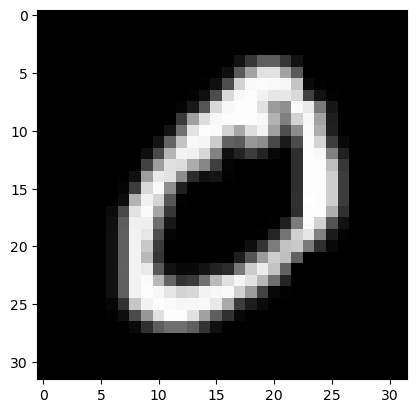

In [48]:
image, label = train_set[1]
print(image.shape)
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [49]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set = Subset(train_set, val_idx)
train_set = Subset(train_set, train_idx)
print(train_set)

In [50]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)


In [51]:
import torch.nn as nn

In [52]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (2, 2),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        
        x = self.conv1(x) 
        
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [53]:
class VGG16(nn.Module):

  def __init__(self, input_size, num_classes=10,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)

    return x

In [54]:
# Create the model
model = VGG16((1,32,32),batch_norm=True)
print(model)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

In [55]:
# Get an element from the dataset
test_x, _ = train_set[100] # each element of the dataset is a couple (image, label)
test_x = test_x.unsqueeze(dim=0)

In [56]:
# Get the size of a sample
test_x.size()

torch.Size([1, 1, 32, 32])

In [57]:
test_x_np = test_x.numpy()
print(test_x_np)
test_x_flattened = test_x_np.ravel()

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


In [58]:
# Writing the flattened array to a text file
with open('flat_test_x.txt', 'w') as file:
    for value in test_x_flattened:
        file.write(str(value) + '\n')

In [59]:
def apply_conv2d(batch):
    # Check if CUDA is available and then set the device to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')
    
    # Define a Conv2D layer
    
    # Parameters: in_channels (1), out_channels (64), kernel_size (default is 2)
    conv_layer = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=1, stride=1)
    
    # Manually initialize weights to a fixed value - 0.1
    nn.init.constant_(conv_layer.weight, 0.1)

    # initialize biases to a fixed value
    nn.init.constant_(conv_layer.bias, 0)

    current_weights_numpy = conv_layer.weight.data.cpu().numpy()
    
    print(current_weights_numpy.shape)
    
    # Apply the conv layer to the batch
    # Assuming the batch is of the shape (batch_size, channels, height, width)
    output = conv_layer(batch)
    
    # Move the conv layer to the GPU
    conv_layer = conv_layer.to(device)

    # Move the batch to the GPU
    batch = batch.to(device)

    # Apply the conv layer to the batch
    output = conv_layer(batch)

    return output

In [60]:
# Time this - Pytorch Convolution
import time
start_time = time.time()
output = apply_conv2d(test_x)
end_time = time.time()
total_time = end_time - start_time
print(f"Total running time: {total_time} seconds")


Using device: cpu
(64, 1, 2, 2)
Total running time: 0.021170854568481445 seconds


In [61]:
tracker.start()
output = apply_conv2d(test_x)
emission:float =tracker.stop()
print(f"Emission: {emission} kg")

[codecarbon INFO @ 17:48:23] Energy consumed for RAM : 0.000000 kWh. RAM Power : 70.35811042785645 W
[codecarbon INFO @ 17:48:23] Energy consumed for all CPUs : 0.000000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:48:23] 0.000000 kWh of electricity used since the beginning.


Using device: cpu
(64, 1, 2, 2)
Emission: 3.2904493972453324e-08 kg


# Run kn2row Convolution With Sycl

In [31]:

### 
run_kn2row_conv_sycl = """#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling kn2row
icpx -fsycl -fsycl-device-code-split=per_kernel -DMKL_ILP64 -I$MKLROOT/include -L$MKLROOT/lib/intel64 -lmkl_sycl -lmkl_intel_ilp64 -lmkl_sequential -lmkl_core -lsycl -lOpenCL -lpthread -lm -ldl kn2row_conv_sycl.cpp -o kn2row_conv_sycl
if [ $? -eq 0 ]; then ./kn2row_conv_sycl; fi
"""

with open("run_kn2row_conv_sycl.sh", "w") as f:
    f.write(run_kn2row_conv_sycl)


In [32]:
!chmod 755 q; chmod 755 run_kn2row_conv_sycl.sh; if [ -x "$(command -v qsub)" ]; then ./q run_kn2row_conv_sycl.sh; fi


Job has been submitted to Intel(R) DevCloud and will execute soon.

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2448655.v-qsvr-1           ...ub-singleuser u205840         00:00:35 R jupyterhub     
2448669.v-qsvr-1           ..._conv_sycl.sh u205840                0 Q batch          

Waiting for Output ███████████████████████████████████ Done⬇

########################################################################
#      Date:           Fri Dec 15 05:43:27 PM PST 2023
#    Job ID:           2448669.v-qsvr-1.aidevcloud
#      User:           u205840
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u205840 is compiling kn2row

########################################################################
# End of output for job 2448669.v-qsvr-1.aidevcloud
# Date:

# Run kn2row Convolution without Sycl

In [33]:
### 
run_kn2row_nonsycl = """#!/bin/bash
source /opt/intel/oneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling kn2row
icpx -o kn2row_conv_nonsycl kn2row_conv_nonsycl.cpp -lmkl_rt
if [ $? -eq 0 ]; then ./kn2row_conv_nonsycl; fi
"""

with open("run_kn2row_conv_nonsycl.sh", "w") as f:
    f.write(run_kn2row_nonsycl)

In [34]:
!chmod 755 q; chmod 755 run_kn2row_conv_nonsycl.sh; if [ -x "$(command -v qsub)" ]; then ./q run_kn2row_conv_nonsycl.sh; fi


Job has been submitted to Intel(R) DevCloud and will execute soon.

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2448655.v-qsvr-1           ...ub-singleuser u205840         00:00:38 R jupyterhub     
2448670.v-qsvr-1           ...nv_nonsycl.sh u205840                0 Q batch          

Waiting for Output █████████ Done⬇

########################################################################
#      Date:           Fri Dec 15 05:44:03 PM PST 2023
#    Job ID:           2448670.v-qsvr-1.aidevcloud
#      User:           u205840
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u205840 is compiling kn2row

########################################################################
# End of output for job 2448670.v-qsvr-1.aidevcloud
# Date: Fri Dec 15 05:44:08 PM PS

In [35]:
!qstat


Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2448655.v-qsvr-1           ...ub-singleuser u205840         00:00:38 R jupyterhub     


In [36]:
# Create the model
model = VGG16((1,32,32), batch_norm=True)
output = model(test_x)
output.shape

torch.Size([1, 512, 3, 3])

In [37]:
torch.cuda.is_available()

False

In [38]:
dev = torch.device('xpu')
print(dev)

xpu


In [39]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss
criterion = nn.CrossEntropyLoss()

In [40]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = False, model_name="valerio"):
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    #labels = labels.unsqueeze(1)
                    labels = labels.long()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    #pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    _,pred_label = torch.max(pred, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
#     finally:
#         # Plot loss
#         plt.title("Loss")
#         for split in ["train", "val", "test"]:
#             plt.plot(history_loss[split], label=split)
#         plt.legend()
#         plt.show()
#         # Plot accuracy
#         plt.title("Accuracy")
#         for split in ["train", "val", "test"]:
#             plt.plot(history_accuracy[split], label=split)
#         plt.legend()
#         plt.show()

In [41]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)